# Words Classification

In this document the classification of words is performed using the embeddings, both in CLASS layer and in the second hierarchical level whether it is a SECTION or DIVISION.

We start by importing all the necessary libraries, that will be used.

In [1]:
import pandas as pd
import numpy as np
from nomic import embed
import chromadb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score


We then load the word with the hierarchy from the csv file and create a dataframe to store the words and remove the # and the numbers from the words.

In [2]:
# Load the word with the hierarchy from the csv file
complete = pd.read_csv('bold_words_with_numbers3.txt', header=None, names=['word'])

# Create a dataframe to store the words
df = complete.copy()

# Remove the # and the numbers from the words
df['word'] = df['word'].str.replace(r'#\d+[a-z]?\.\s*', '', regex=True)

#keep only the words that are not empty
df = df[df['word'].str.len() > 0]

#remove any remaining cases
df['word'] = df['word'].str.replace(r'#\d+[a-z]\s+', '', regex=True)

df

,word
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS
1,SECTION I. EXISTENCE
2,Existence
3,Inexistence
4,Substantiality
...,...
1102,Clergy
1103,Laity
1104,Rite
1105,Canonicals


After that the initialisation of the class number and the sec/div number columns is performed.

In [3]:
#Initialise the Class number and the Sec/Div number columns
# Create the class number
df['class'] = 0

# Create the section/division number
df['sec_div'] = 0

df

,word,class,sec_div
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,0,0
1,SECTION I. EXISTENCE,0,0
2,Existence,0,0
3,Inexistence,0,0
4,Substantiality,0,0
...,...,...,...
1102,Clergy,0,0
1103,Laity,0,0
1104,Rite,0,0
1105,Canonicals,0,0


The below function `process_hierarchy` processes a DataFrame by iterating through each row to manage counters related to classes and sections or divisions within a document. Initially, it looks for 'CLASS' in the 'word' column to start the new counts. When a 'CLASS' is found the class counter is incremented and it resets the section/division counter and starts looking for 'SECTION' or 'DIVISION'. If 'SECTION' or 'DIVISION' is found, it increments the counter. Finding a 'DIVISION' changes the focus solely to 'DIVISION' until the next 'CLASS' is encountered. Finally, it assigns these counters to the new columns 'class' and 'sec_div' and removes any rows containing 'CLASS', 'SECTION', or 'DIVISION' keywords, returning the cleaned DataFrame.

In [4]:
def process_hierarchy(df):
    class_counter = 0
    sec_div_counter = 0
    looking_for = 'CLASS'  # Start by looking for 'CLASS'
    
    for index, row in df.iterrows():
        word = row['word']
        
        # Check for 'CLASS' and increment class counter
        if 'CLASS' in word:
            class_counter += 1
            sec_div_counter = 0  # Reset section/division counter
            looking_for = 'SECTION'  # Start looking for 'SECTION' by default
        
        # Check for 'SECTION' or 'DIVISION' and increment section/division counter
        elif looking_for == 'SECTION' and 'SECTION' in word or 'DIVISION' in word:
            sec_div_counter += 1
            # If 'DIVISION' is found, only look for 'DIVISION' until the next 'CLASS'
            if 'DIVISION' in word:
                looking_for = 'DIVISION'
        
        # Assign class counter and section/division counter to the current row
        df.at[index, 'class'] = class_counter
        df.at[index, 'sec_div'] = sec_div_counter
        
    df = df[~df['word'].str.contains('CLASS|SECTION|DIVISION')]
    
    return df

In [5]:
# run the function to process the hierarchy
df = process_hierarchy(df)

#preview the dataframe
df

,word,class,sec_div
2,Existence,1,1
3,Inexistence,1,1
4,Substantiality,1,1
5,Unsubstantiality,1,1
6,Intrinsicality,1,1
...,...,...,...
1102,Clergy,6,5
1103,Laity,6,5
1104,Rite,6,5
1105,Canonicals,6,5


Then the embeddings are retrieved using the `embed.text` method from the nomic library. The `model` parameter is set to `nomic-embed-text-v1` and the `task_type` parameter is set to `classification` for the generation of embeddings catered to classification.

In [26]:
#retrieve the embeddings from the nomic library
output = embed.text(
    texts=df['word'].tolist(),
    model='nomic-embed-text-v1',
    task_type='classification',
)

The chromadb client is initialised to interact with the vector database and a collection called `nomic_classification` is created. The documents, embeddings, metadatas, and ids are added to the collection.

In [6]:
#Create a client to interact with the vector database
chroma_client = chromadb.PersistentClient("./chromadb")

In [3]:
#create a collection called nomic_clustering
collection = chroma_client.create_collection(name="nomic_classification")

In [4]:
#add the documents, embeddings, metadatas, and ids to the collection
collection.add(
    documents=df['word'].tolist(),
    embeddings=output['embeddings'],
    metadatas=[{"word": word} for word in df['word'].tolist()],
    ids=[f"word{i}" for i in range(len(df['word'].tolist()))]
)

In [7]:
#get the collection
collection = chroma_client.get_collection(name="nomic_classification")

In [5]:
#delete the collection if needed
#chroma_client.delete_collection(name="nomic_clustering")

The embeddings and the words are retrieved from the collection and the classification is created with the embeddings. The duplicates are dropped and the classification is merged with the original dataframe to add the class and sec_div columns.

In [8]:
#retrieve the embeddings and the words from the collection
embeddings = collection.get(include=["embeddings", "documents"])['embeddings']
words = collection.get(include=["embeddings", "documents"])['documents']

classification = pd.DataFrame(embeddings)

classification['word'] = words

#drop duplicates
classification = classification.drop_duplicates(subset='word')

#merge the classification with the original dataframe to add the class and sec_div columns
classification = classification.merge(df, on='word')

#show the classification
classification

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,word,class,sec_div
0,-0.029755,-0.026367,-0.012779,-0.047302,0.025482,0.067017,0.004402,0.016739,-0.065491,0.003429,...,-0.004848,0.023834,0.031921,0.008949,0.039398,-0.033813,0.005913,Existence,1,1
1,-0.010292,0.019257,-0.017593,-0.038849,0.025085,0.058319,0.003544,0.032318,-0.047516,-0.004955,...,0.003414,-0.006088,0.015236,-0.028397,0.063965,-0.087158,-0.001468,Inexistence,1,1
2,0.038696,-0.010262,-0.013084,-0.060669,-0.034119,0.018646,0.014557,0.017441,-0.054077,-0.009644,...,0.021851,-0.002119,0.053833,0.003244,0.031021,-0.066040,-0.023254,Consanguinity,1,2
3,0.007351,-0.001904,-0.016907,-0.080200,-0.023941,0.006577,0.042511,0.013557,-0.055969,0.013985,...,0.022186,0.027924,-0.003046,0.032745,0.010971,-0.052429,-0.011940,Trisection,1,5
4,0.033813,0.013992,-0.030975,-0.040100,-0.025711,0.073120,0.034760,-0.000263,-0.023941,-0.001348,...,-0.008667,0.004883,0.051147,-0.006226,-0.013985,-0.035614,-0.030762,Innocence,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,0.003222,0.012016,-0.026779,-0.062622,-0.029129,-0.013229,-0.036713,0.031189,-0.044830,-0.008881,...,-0.004864,-0.006489,0.029816,0.028076,0.011002,-0.025818,-0.019547,Knave,6,4
1053,-0.017761,0.020966,-0.022141,-0.068909,-0.021332,0.077820,0.061707,0.007278,-0.046021,-0.044373,...,0.009666,-0.001984,0.058655,0.011986,0.012474,-0.026489,-0.018188,Disinterestedness,6,4
1054,0.010719,0.049469,-0.036987,-0.062286,0.003099,0.019135,0.003527,-0.003384,-0.029724,0.024185,...,-0.005856,0.006557,0.037598,0.008789,0.003222,-0.040863,-0.024185,Selfishness,6,4
1055,0.020142,0.006626,-0.035675,-0.046814,-0.005482,0.024155,0.011139,-0.030060,0.010170,-0.009857,...,-0.014580,0.026886,0.042694,0.005581,-0.009171,-0.081665,-0.013771,Virtue,6,4


## Classification on the CLASS layer

After the classification dataframe is created, we are able to begin the classification process on CLASS level.

The data is prepared for the classification by dropping the word, class, and sec_div columns and the X and y are created then data is split into training and testing sets. 

In [9]:
#prepare the data for the classification
X = classification.drop(['word', 'class', 'sec_div'], axis=1)

y = classification['class']-1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

After that the logistic regression is performed to classify the words and the classification report is printed.

In [10]:
# perform logistic regression to classify the words
logisticRegr = LogisticRegression(max_iter=1000)

logisticRegr.fit(X_train, y_train)

predictions = logisticRegr.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66        41
           1       0.75      0.50      0.60        30
           2       0.57      0.52      0.54        25
           3       0.58      0.54      0.56        28
           4       0.61      0.69      0.65        49
           5       0.67      0.79      0.73        39

    accuracy                           0.64       212
   macro avg       0.64      0.62      0.62       212
weighted avg       0.64      0.64      0.63       212


We can see that the accuracy is 0.64, which is not very high. We can use optuna to optimize the hyperparameters of the logistic regression.

In [19]:
# use optuna to optimize the hyperparameters of the logistic regression
def objective_log(trial):
    
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l2', None])
    
    C = trial.suggest_float('C', 1e-5, 1e5, log=True)
    
    # Create the model
    logisticRegr = LogisticRegression(penalty=penalty, C=C, max_iter=1000)
    
    # Fit the model
    logisticRegr.fit(X_train, y_train)
    
    # Predict the model
    predictions = logisticRegr.predict(X_test)
    
    # Return the accuracy
    return classification_report(y_test, predictions, output_dict=True , zero_division=0)['accuracy']

# Create the study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective_log, n_trials=50)

#print the best parameters
print(study.best_params)

# Get the best parameters
best_params = study.best_params

#run the logistic regression with the best parameters
logisticRegr = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], max_iter=1000)

logisticRegr.fit(X_train, y_train)

predictions = logisticRegr.predict(X_test)

print(classification_report(y_test, predictions))

[I 2024-02-24 15:21:29,857] A new study created in memory with name: no-name-f70d9131-f002-40b5-b915-cd25875543a6
C:\Users\Pumukl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2024-02-24 15:21:29,939] Trial 0 finished with value: 0.6037735849056604 and parameters: {'penalty': None, 'C': 0.025811986200456105}. Best is trial 0 with value: 0.6037735849056604.
[I 2024-02-24 15:21:30,076] Trial 1 finished with value: 0.6462264150943396 and parameters: {'penalty': 'l2', 'C': 544.7446567924222}. Best is trial 1 with value: 0.6462264150943396.
[I 2024-02-24 15:21:30,102] Trial 2 finished with value: 0.25 and parameters: {'penalty': 'l2', 'C': 0.04078442486190641}. Best is trial 1 with value: 0.6462264150943396.
C:\Users\Pumukl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting pena

{'penalty': 'l2', 'C': 5.449257421576762}
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        41
           1       0.81      0.70      0.75        30
           2       0.64      0.64      0.64        25
           3       0.54      0.54      0.54        28
           4       0.67      0.69      0.68        49
           5       0.69      0.79      0.74        39

    accuracy                           0.69       212
   macro avg       0.69      0.68      0.68       212
weighted avg       0.69      0.69      0.69       212


There is some improvement in the accuracy, from 0.64 to 0.69.

Let's try to use other models to classify the words.

We move on with support vector machine (SVM) to classify the words

In [12]:
# perform svm to classify the words
svm = SVC()

svm.fit(X_train, y_train)

predictions = svm.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64        41
           1       0.80      0.53      0.64        30
           2       0.61      0.68      0.64        25
           3       0.61      0.50      0.55        28
           4       0.61      0.78      0.68        49
           5       0.69      0.74      0.72        39

    accuracy                           0.66       212
   macro avg       0.67      0.64      0.65       212
weighted avg       0.66      0.66      0.65       212


This is better than the logistic regression, but we can use optuna to optimize the hyperparameters of the SVM.

In [17]:
# Create an optuna function to optimize the hyperparameters of the SVM
def objective_svm(trial):
    
    # Define the hyperparameters to optimize
    C = trial.suggest_float('C', 1e-5, 1e5, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    # Create the model
    svm = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
    
    # Fit the model
    svm.fit(X_train, y_train)
    
    # Predict the model
    predictions = svm.predict(X_test)
    
    # Return the accuracy
    return classification_report(y_test, predictions,  output_dict=True, zero_division=0)['accuracy']

# Create the study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective_svm, n_trials=50)

# print the classification report with the best parameters
best_params_svm = study.best_params

svm = SVC(C=best_params_svm['C'], kernel=best_params_svm['kernel'], degree=best_params_svm['degree'], gamma=best_params_svm['gamma'])

svm.fit(X_train, y_train)

predictions = svm.predict(X_test)

print(classification_report(y_test, predictions))

[I 2024-02-24 15:19:53,884] A new study created in memory with name: no-name-a4c134aa-a83f-4501-ba4f-8a3dcfa7adc0
[I 2024-02-24 15:19:54,053] Trial 0 finished with value: 0.23113207547169812 and parameters: {'C': 7.383911021345929, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto'}. Best is trial 0 with value: 0.23113207547169812.
[I 2024-02-24 15:19:54,197] Trial 1 finished with value: 0.23113207547169812 and parameters: {'C': 1.9890683490482823e-05, 'kernel': 'linear', 'degree': 8, 'gamma': 'auto'}. Best is trial 0 with value: 0.23113207547169812.
[I 2024-02-24 15:19:54,346] Trial 2 finished with value: 0.23113207547169812 and parameters: {'C': 3550.4214778294036, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'}. Best is trial 0 with value: 0.23113207547169812.
[I 2024-02-24 15:19:54,470] Trial 3 finished with value: 0.6179245283018868 and parameters: {'C': 110.20925536699872, 'kernel': 'linear', 'degree': 8, 'gamma': 'auto'}. Best is trial 3 with value: 0.6179245283018868.
[I 2024-02

              precision    recall  f1-score   support

           0       0.67      0.71      0.69        41
           1       0.83      0.67      0.74        30
           2       0.74      0.80      0.77        25
           3       0.65      0.61      0.63        28
           4       0.69      0.71      0.70        49
           5       0.73      0.77      0.75        39

    accuracy                           0.71       212
   macro avg       0.72      0.71      0.71       212
weighted avg       0.72      0.71      0.71       212


There is a significant improvement of the original accuracy of 0.66 to 0.71.

We move on with stochastic gradient descent (SGD) to classify the words with the default parameters.

In [14]:
#perform SGD to classify the words
sgd = SGDClassifier()

sgd.fit(X_train, y_train)

predictions = sgd.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72        41
           1       0.81      0.70      0.75        30
           2       0.54      0.80      0.65        25
           3       0.61      0.50      0.55        28
           4       0.74      0.71      0.73        49
           5       0.68      0.69      0.68        39

    accuracy                           0.69       212
   macro avg       0.69      0.69      0.68       212
weighted avg       0.70      0.69      0.69       212


The accuracy is 0.69, which is not very high. We can use optuna to optimize the hyperparameters of the SGD.

In [18]:
# Create an optuna function to optimize the hyperparameters of the SGD
def objective_sgd(trial):
    # Define the hyperparameters to optimize
    loss = trial.suggest_categorical('loss', ['hinge', 'log_loss', 'squared_hinge', 'perceptron'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive'])
    eta0 = trial.suggest_float('eta0', 1e-5, 1e-1, log=True)  # Only relevant for certain learning rates
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    
    # Create the model
    sgd = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha, learning_rate=learning_rate, eta0=eta0, l1_ratio=l1_ratio)
    
    # Fit the model
    sgd.fit(X_train, y_train)
    
    # Predict the model
    predictions = sgd.predict(X_test)
    
    # Return the accuracy
    return classification_report(y_test, predictions, output_dict=True, zero_division=0)['accuracy']

# Create the study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective_sgd, n_trials=50)

# Get the best parameters
best_params = study.best_params

#create the classification with the best parameters
sgd = SGDClassifier(loss=best_params['loss'], penalty=best_params['penalty'], alpha=best_params['alpha'], learning_rate=best_params['learning_rate'], eta0=best_params['eta0'], l1_ratio=best_params['l1_ratio'])

sgd.fit(X_train, y_train)

predictions = sgd.predict(X_test)

print(classification_report(y_test, predictions))

[I 2024-02-24 15:20:44,057] A new study created in memory with name: no-name-e63504f9-09aa-4ebc-b06d-32a99c147384
[I 2024-02-24 15:20:44,973] Trial 0 finished with value: 0.6179245283018868 and parameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 8.869158359672956e-05, 'learning_rate': 'adaptive', 'eta0': 0.006292980805760247, 'l1_ratio': 0.7879974154984328}. Best is trial 0 with value: 0.6179245283018868.
[I 2024-02-24 15:20:45,108] Trial 1 finished with value: 0.23113207547169812 and parameters: {'loss': 'perceptron', 'penalty': 'l1', 'alpha': 0.004898312514319803, 'learning_rate': 'invscaling', 'eta0': 0.0005620474353849702, 'l1_ratio': 0.7360326034538617}. Best is trial 0 with value: 0.6179245283018868.
[I 2024-02-24 15:20:45,753] Trial 2 finished with value: 0.6226415094339622 and parameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0003702331750030169, 'learning_rate': 'optimal', 'eta0': 1.1230655325593459e-05, 'l1_ratio': 0.43099553993029105}. Best is trial

              precision    recall  f1-score   support

           0       0.78      0.68      0.73        41
           1       0.81      0.73      0.77        30
           2       0.64      0.72      0.68        25
           3       0.52      0.54      0.53        28
           4       0.74      0.69      0.72        49
           5       0.65      0.77      0.71        39

    accuracy                           0.69       212
   macro avg       0.69      0.69      0.69       212
weighted avg       0.70      0.69      0.69       212


The accuracy is 0.69, which is the same as the default parameters with some small improvements in the macro avg

Continue with random forest

In [16]:
# Perform random forest to classify the words
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59        41
           1       0.65      0.37      0.47        30
           2       0.58      0.60      0.59        25
           3       0.54      0.46      0.50        28
           4       0.56      0.73      0.64        49
           5       0.62      0.64      0.63        39

    accuracy                           0.58       212
   macro avg       0.59      0.57      0.57       212
weighted avg       0.59      0.58      0.58       212


the value of the accuracy is 0.58 is significantly lower than the other models, lets check if we can optimize the hyperparameters of the random forest.

In [21]:
# Create an optuna function to optimize the hyperparameters of the random forest
def objective_rf(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_int('max_features', 1, 50)
    
    # Create the model
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features)
    
    # Fit the model
    rf.fit(X_train, y_train)
    
    # Predict the model
    predictions = rf.predict(X_test)
    
    # Return the accuracy
    return classification_report(y_test, predictions, output_dict=True, zero_division=0)['accuracy']

# Create the study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective_rf, n_trials=35)

# Get the best parameters
best_params = study.best_params

# Create the random forest with the best parameters
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], criterion=best_params['criterion'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'], max_features=best_params['max_features'])

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

print(classification_report(y_test, predictions))

[I 2024-02-24 15:23:31,794] A new study created in memory with name: no-name-3a35ac53-d06f-4180-bcf1-cfa16d65a5f4
[I 2024-02-24 15:23:34,453] Trial 0 finished with value: 0.589622641509434 and parameters: {'n_estimators': 137, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 13}. Best is trial 0 with value: 0.589622641509434.
[I 2024-02-24 15:23:34,952] Trial 1 finished with value: 0.5707547169811321 and parameters: {'n_estimators': 48, 'criterion': 'gini', 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 22}. Best is trial 0 with value: 0.589622641509434.
[I 2024-02-24 15:23:37,513] Trial 2 finished with value: 0.5943396226415094 and parameters: {'n_estimators': 190, 'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 18}. Best is trial 2 with value: 0.5943396226415094.
[I 2024-02-24 15:23:37,683] Trial 3 finished with value: 0.44339622641509435 and pa

              precision    recall  f1-score   support

           0       0.60      0.63      0.62        41
           1       0.93      0.43      0.59        30
           2       0.62      0.52      0.57        25
           3       0.55      0.39      0.46        28
           4       0.51      0.71      0.60        49
           5       0.63      0.74      0.68        39

    accuracy                           0.60       212
   macro avg       0.64      0.57      0.59       212
weighted avg       0.63      0.60      0.59       212


That was not much of an improvement.

Continue with xgboost

In [18]:
#perform xgboost to classify the words
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train, y_train)

predictions = xg_reg.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48        41
           1       0.60      0.30      0.40        30
           2       0.49      0.68      0.57        25
           3       0.47      0.32      0.38        28
           4       0.52      0.63      0.57        49
           5       0.60      0.62      0.61        39

    accuracy                           0.52       212
   macro avg       0.52      0.51      0.50       212
weighted avg       0.52      0.52      0.51       212


these are the lowest results so far, moving on with catboost

In [19]:
#perform catboost to classify the words
cat = CatBoostClassifier(task_type='GPU')

cat.fit(X_train, y_train)

predictions = cat.predict(X_test)

print(classification_report(y_test, predictions))

Learning rate set to 0.062714
0:	learn: 1.7636051	total: 52.5ms	remaining: 52.5s
1:	learn: 1.7363956	total: 82.6ms	remaining: 41.2s
2:	learn: 1.7107153	total: 111ms	remaining: 36.8s
3:	learn: 1.6845616	total: 140ms	remaining: 34.8s
4:	learn: 1.6581248	total: 169ms	remaining: 33.6s
5:	learn: 1.6343432	total: 197ms	remaining: 32.6s
6:	learn: 1.6110658	total: 224ms	remaining: 31.8s
7:	learn: 1.5885057	total: 253ms	remaining: 31.4s
8:	learn: 1.5687516	total: 283ms	remaining: 31.2s
9:	learn: 1.5482964	total: 312ms	remaining: 30.9s
10:	learn: 1.5271912	total: 341ms	remaining: 30.7s
11:	learn: 1.5059656	total: 371ms	remaining: 30.5s
12:	learn: 1.4851258	total: 400ms	remaining: 30.4s
13:	learn: 1.4649072	total: 429ms	remaining: 30.2s
14:	learn: 1.4459413	total: 459ms	remaining: 30.1s
15:	learn: 1.4262279	total: 487ms	remaining: 29.9s
16:	learn: 1.4079109	total: 517ms	remaining: 29.9s
17:	learn: 1.3894144	total: 546ms	remaining: 29.8s
18:	learn: 1.3725280	total: 576ms	remaining: 29.7s
19:	learn

We get an accuracy of 0.61, which is not higher than the other models, even without optimization.

Finally we move on with neural networks

We start by one-hot encoding both y training and y test labels to accommodate the 6-class output, and then proceed to build a sequential neural network model. The sequential architecture starts with a dense layer of 32 units with 'relu' activation, adapted for 768 input features, and incorporates L1 and L2 regularization to mitigate overfitting. Following this, batch normalization is applied to stabilize learning, succeeded by a substantial dropout rate of 0.6 to further prevent overfitting. Another 'relu' activated dense layer with 12 units also includes regularization, succeeded by batch normalization, leading in a softmax-activated dense layer for class prediction. The model employs the Adam optimizer and categorical crossentropy loss function, with accuracy as the performance metric.
 
An EarlyStopping callback is integrated to cease training if no improvement in validation loss is observed for 10 epochs. The training process, is set for a maximum of 40 epochs with a batch size of 32 and utilizing 20% of the data for validation. Finaly the model's performance is evaluated on the test set, through the loss and accuracy metrics.

In [149]:
# Encode the labels if they are categorical
y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)
model = Sequential([
    Dense(32, activation='relu', input_shape=(768,), kernel_regularizer=l1_l2(l1=0.001, l2=0.001)), 
    BatchNormalization(),
    Dropout(0.6),  # Increased dropout rate
    Dense(12, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dense(6, activation='softmax') 
])

# Compile the model with a smaller learning rate
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback to stop training when no improvement in val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with encoded labels and callbacks
history = model.fit(
    X_train, y_train_encoded, 
    epochs=40,  # Increase if needed
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping]
)

# Evaluate the model with encoded labels
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/40
22/22 [==============================] - 3s 14ms/step - loss: 3.3141 - accuracy: 0.1760 - val_loss: 2.9438 - val_accuracy: 0.1775
Epoch 2/40
22/22 [==============================] - 0s 4ms/step - loss: 2.9921 - accuracy: 0.2633 - val_loss: 2.8885 - val_accuracy: 0.1598
Epoch 3/40
22/22 [==============================] - 0s 3ms/step - loss: 2.7888 - accuracy: 0.3402 - val_loss: 2.8384 - val_accuracy: 0.1598
Epoch 4/40
22/22 [==============================] - 0s 3ms/step - loss: 2.6163 - accuracy: 0.3757 - val_loss: 2.7894 - val_accuracy: 0.1598
Epoch 5/40
22/22 [==============================] - 0s 3ms/step - loss: 2.5065 - accuracy: 0.3994 - val_loss: 2.7428 - val_accuracy: 0.1598
Epoch 6/40
22/22 [==============================] - 0s 3ms/step - loss: 2.4619 - accuracy: 0.4231 - val_loss: 2.6920 - val_accuracy: 0.1834
Epoch 7/40
22/22 [==============================] - 0s 3ms/step - loss: 2.3437 - accuracy: 0.4630 - val_loss: 2.6397 - val_accuracy: 0.2426
Epoch 8/40
22/22 [=

The accuracy is 0.65 which is around the same as the other models.

Checking the best epoch

In [150]:
#print best epoch
best_epoch = np.argmin(history.history['val_loss']) + 1
best_epoch

40

Then we create two subplots to visualize the training and validation accuracy and loss over the epochs, and to check for overfitting.

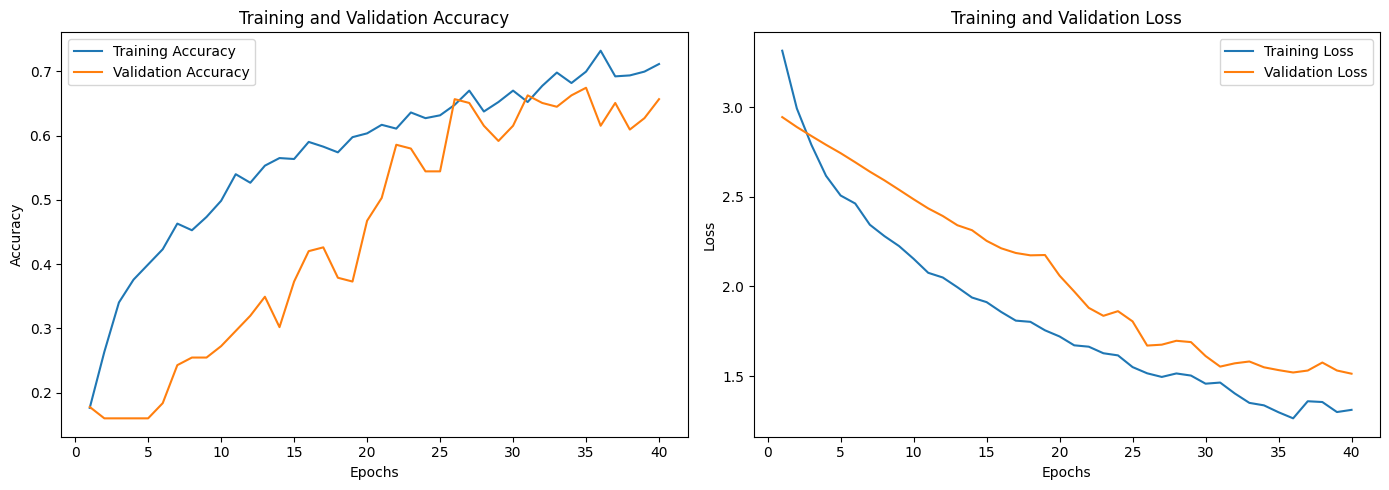

In [151]:
# Retrieve the history data from the history object
history_data = history.history

# List of epochs
epochs = range(1, len(history_data['accuracy']) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_data['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, history_data['loss'], label='Training Loss')
plt.plot(epochs, history_data['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

***Discussion I***

The training and validation accuracy and loss plots, with the best epoch being 40, do not strongly suggest overfitting, as the validation accuracy does not significantly diverge from the training accuracy, and the validation loss does not show a rising trend. While the training accuracy continues to improve slightly, the validation accuracy plateaus with some fluctuation, but without a distinct downward trend. Similarly, the training loss decreases steadily, and the validation loss levels off without increasing.

***Discussion II***

Based on the classification results, the support vector machine (SVM) model with optimized hyperparameters achieved the highest accuracy of 0.71. An accuracy of 0.71 means that the SVM model correctly predicted the class labels for 71% of the instances in the test dataset or in other words, for each 100 words the model correctly predicted the correct CLASSES of the words 71 times.

## Classification on the second hierarchical level (SECTION/DIVISION)

To tackle this problem, we will take the model with the best accuracy, which is the SVM model, and adapt it for multi-label classification. We will use the MultiOutputClassifier from scikit-learn to adapt the SVM model for multi-label classification. The MultiOutputClassifier is a simple strategy for extending classifiers that do not natively support multi-target classification. It works by fitting one classifier per target.

We start by creating a new Y_train and Y_test with both the class and the sec_div

In [30]:
# Make a new Y_train and Y_test with both the class and the sec_div
Y = classification[['class', 'sec_div']]-1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

We then initialize the multioutput classifier and fit the model with the optimal hyperparameters of the previous SVM model.

In [154]:
base_classifier = SVC(C=best_params_svm['C'], kernel=best_params_svm['kernel'], degree=best_params_svm['degree'], gamma=best_params_svm['gamma'])

# Adapt SVM for multi-label classification
multi_label_svm = MultiOutputClassifier(base_classifier)

Finally we fit and predict the model while also evaluating the accuracy for each target.

In [155]:
#initialize the multioutput classifier
multi_target_classifier = MultiOutputClassifier(base_classifier)

#fit the model
multi_target_classifier.fit(X_train, Y_train)

#predict the model
predictions = multi_target_classifier.predict(X_test)

# Example evaluation for each target
for i in range(Y_test.shape[1]):
    # Use .iloc to select all rows and the ith column for both Y_test and predictions
    accuracy = accuracy_score(Y_test.iloc[:, i], predictions[:, i])
    print(f"Target {i} accuracy: {accuracy}")

Target 0 accuracy: 0.7122641509433962
Target 1 accuracy: 0.5330188679245284


Target 0 accuracy: The accuracy of 0.71 for Target 0 means that for the first classification task, the model correctly predicted the class labels 71.23% of the time. Which is some thing that we have already seen in the previous classification.

Target 1 accuracy: The accuracy of 0.53 for Target 1 means that for the second classification task, the model correctly predicted the section/division labels 53.30% of the time. This is lower than the first classification task, which is expected as the second classification task is more complex than the first one.

finally we can calculate the multi-output accuracy

The below code compares all predicted labels to the true labels for each sample and computes the average of completely correct predictions across the dataset.

In [157]:
accuracy = np.mean(np.all(Y_test == predictions, axis=1))
print(f"Multi-output Accuracy: {accuracy}")

Multi-output Accuracy: 0.44339622641509435


From the above accuracy of 0.44, we can see that the model correctly predicted the class and section/division labels for 44% of the instances in the test dataset.
